In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [105]:
df = pd.read_csv("../Data/Copy of hackathon_customerData_challenge2.csv")
df.head()

,customerID,Date_UTC,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21T18:00:00.000Z,2022-10-22,15,4099.0,NaN
1,793,2022-10-21T18:15:00.000Z,2022-10-22,15,5566.0,NaN
2,793,2022-10-21T18:30:00.000Z,2022-10-22,16,3565.5,NaN
3,793,2022-10-21T18:45:00.000Z,2022-10-22,16,3420.5,NaN
4,793,2022-10-21T19:00:00.000Z,2022-10-22,17,3236.5,NaN


In [106]:
# Drop rows where laod power is 0
df = df[df['load_power_W'] != 0.0]

In [107]:
# Convert date column from str to datetime
df['Date_UTC'] = pd.to_datetime(df['Date_UTC'])

In [ ]:
def delete_rows_before_midnight(customer_id):
    # chosen_id = (df['customerID'] == customer_id) 
    # timestamps = df.loc[chosen_id, 'Date_NZDT']
    # first_midnight_occurrence = timestamps[timestamps.dt.time == pd.Timestamp('00:00:00').time()].head(1)
    # df['customerID'] = df['customerID'][first_midnight_occurrence:]

    #Duplicates the df columns for removing every row before midnight 
    result_df = pd.DataFrame(columns=df.columns)
    for customer_id, group in df.groupby('customerID'):
        midnight_index = group[group['Date_UTC'].dt.time == pd.Timestamp('00:00:00').time()].index.min()
        result_df = pd.concat([result_df, group.loc[midnight_index:]])

    return result_df
# Delete rows before the first midnight occurrence for each customer
df_filtered = delete_rows_before_midnight(df)

# Update the original DataFrame 'df' with the modified 'df_filtered'
df = df_filtered.copy()

In [108]:
df['Date_NZDT'] = df['Date_UTC'] + pd.Timedelta(hours=13)
df.insert(2, 'Date_NZDT', df.pop('Date_NZDT'))
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN


In [109]:
# Spring = 0
# Summer = 1
# Autumn = 2
# Winter = 3

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

# Assuming 'Date_NZDT' is your date column
df['Season'] = df['Date_NZDT'].apply(get_season)
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2


In [110]:
df['average_temp'] = df.groupby(['customerID', 'Date_NZDate'])['weather_Temp_C'].transform(np.mean)
df

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season,average_temp
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...
35038979,592,2023-08-24 18:00:00+00:00,2023-08-25 07:00:00+00:00,2023-08-25,13,261.5,0.800,1,6.173474
35038980,592,2023-08-24 18:15:00+00:00,2023-08-25 07:15:00+00:00,2023-08-25,13,459.0,-0.035,1,6.173474
35038981,592,2023-08-24 18:30:00+00:00,2023-08-25 07:30:00+00:00,2023-08-25,14,359.0,-0.870,1,6.173474
35038982,592,2023-08-24 18:45:00+00:00,2023-08-25 07:45:00+00:00,2023-08-25,14,488.0,-1.370,1,6.173474


In [111]:
def day(num):
    return slice((num - 1) * 96, num * 96 + 1)

day(1)

slice(0, 97, None)

383160   NaN
383161   NaN
383162   NaN
383163   NaN
383164   NaN
          ..
383252   NaN
383253   NaN
383254   NaN
383255   NaN
383256   NaN
Name: weather_Temp_C, Length: 97, dtype: float64


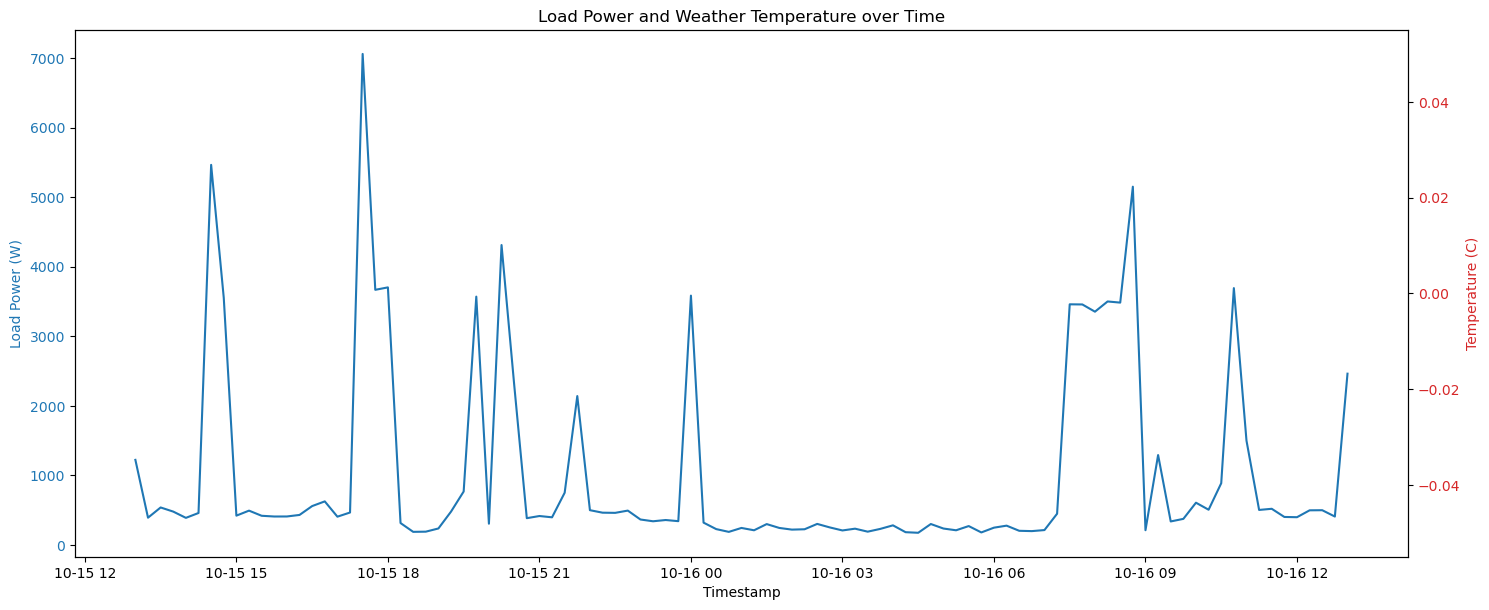

        customerID                  Date_UTC                 Date_NZDT  \
383160         850 2022-10-15 00:00:00+00:00 2022-10-15 13:00:00+00:00   
383161         850 2022-10-15 00:15:00+00:00 2022-10-15 13:15:00+00:00   
383162         850 2022-10-15 00:30:00+00:00 2022-10-15 13:30:00+00:00   
383163         850 2022-10-15 00:45:00+00:00 2022-10-15 13:45:00+00:00   
383164         850 2022-10-15 01:00:00+00:00 2022-10-15 14:00:00+00:00   
383165         850 2022-10-15 01:15:00+00:00 2022-10-15 14:15:00+00:00   
383166         850 2022-10-15 01:30:00+00:00 2022-10-15 14:30:00+00:00   
383167         850 2022-10-15 01:45:00+00:00 2022-10-15 14:45:00+00:00   
383168         850 2022-10-15 02:00:00+00:00 2022-10-15 15:00:00+00:00   
383169         850 2022-10-15 02:15:00+00:00 2022-10-15 15:15:00+00:00   

       Date_NZDate  date_settlementPeriod  load_power_W  weather_Temp_C  \
383160  2022-10-15                     27        1221.5             NaN   
383161  2022-10-15                 

In [112]:
def plot_customer_data(customer_id, day_num):
    df_customer = df[df['customerID'] == customer_id]
    
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Load Power (W)', color=color)
    ax1.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['load_power_W'][day(day_num)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Temperature (C)', color=color)  # we already handled the x-label with ax1
    print(df_customer['weather_Temp_C'][day(day_num)])
    ax2.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['weather_Temp_C'][day(day_num)], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Load Power and Weather Temperature over Time')
    plt.show()

plot_customer_data(850, 1)

print(df[df['customerID'] == 850][0:10])

In [113]:
df.columns

Index(['customerID', 'Date_UTC', 'Date_NZDT', 'Date_NZDate',
       'date_settlementPeriod', 'load_power_W', 'weather_Temp_C', 'Season',
       'average_temp'],
      dtype='object')

<Axes: >

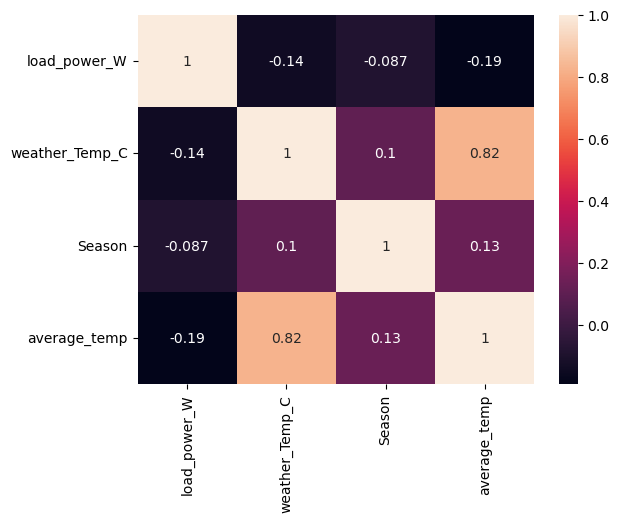

In [116]:
# Assuming df is your DataFrame
correlation_matrix = df[['load_power_W', 'weather_Temp_C', 'Season', 'average_temp']].corr()
sns.heatmap(correlation_matrix, annot=True)


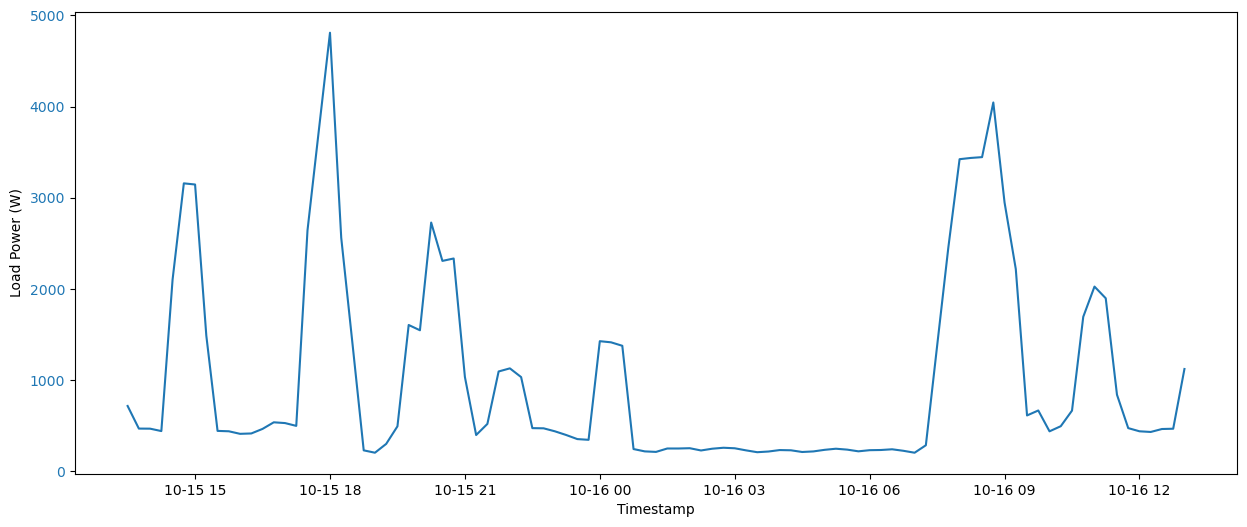

In [13]:
def smoothing_function(column, customer_id, day_num, window_size):
    df_customer = df[df['customerID'] == customer_id]
    smoothed_data = df_customer[column].rolling(window=window_size).mean()
    fig, ax1 = plt.subplots(figsize=(15, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Load Power (W)')
    ax1.plot(df_customer['Date_NZDT'][day(day_num)],smoothed_data[day(day_num)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

smoothed_data = smoothing_function('load_power_W',850, 1, window_size=3)



This code uses the `ruptures` library to generate a piecewise normal signal and detect change points in it. The detected change points can be interpreted as the times when an appliance was turned on or off.

c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

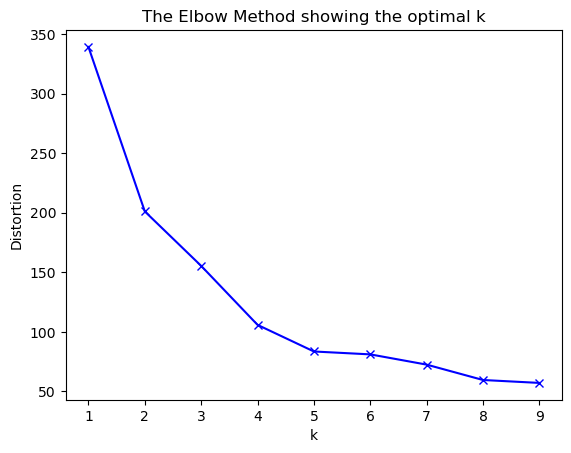

In [14]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

df_no_na_temp = df.dropna(subset=['weather_Temp_C'])

def elbow_method(data):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(data)
        kmeanModel.fit(data)
        distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

# Assuming 'df' is your DataFrame and you want to find clusters based on 'load_power_W' and 'weather_Temp_C'
elbow_method(df_no_na_temp[['load_power_W']][:1000])

c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


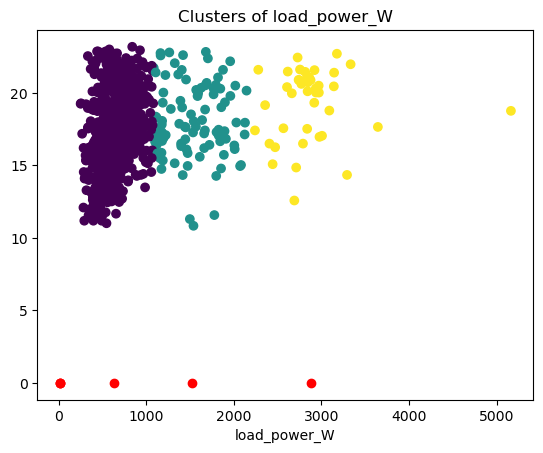

In [15]:
# Number of clusters
k = 3

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k)

# Fit the model to your data
k_model = kmeans.fit(df_no_na_temp[['load_power_W', 'weather_Temp_C']][0:1000])

plt.scatter(df_no_na_temp['load_power_W'][0:1000], df_no_na_temp['weather_Temp_C'][0:1000], c=k_model.labels_)
plt.scatter(k_model.cluster_centers_, np.zeros_like(k_model.cluster_centers_), color='red')  # cluster centers
plt.title('Clusters of load_power_W')
plt.xlabel('load_power_W')
plt.show()

This code uses the `ruptures` library to generate a piecewise normal signal and detect change points in it. The detected change points can be interpreted as the times when an appliance was turned on or off.

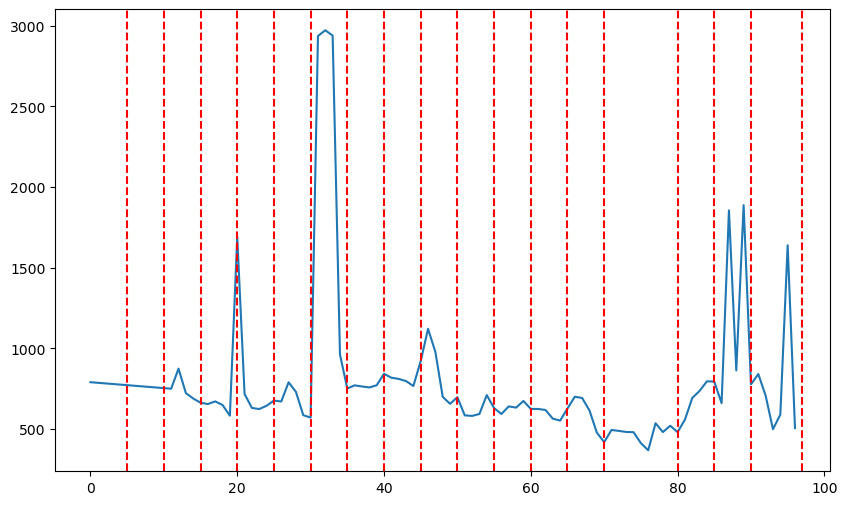

In [34]:
from ruptures import detection

# Select data
data = df_no_na_temp['load_power_W'][day(1)].values

# Change point detection
model = "l1"  # "l1", "rbf", "linear", "normal", "ar"
algo = detection.Pelt(model=model)
result = np.array(algo.fit_predict(data.reshape(-1,1), pen=5))

# Display
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data)
for xc in result:
    ax.axvline(x=xc, color='r', linestyle='--')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

# Select your data
data = df_no_na_temp['load_power_W'].values

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [62]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df_no_na_temp['load_power_W'].values.reshape(-1, 1))

# Convert the series to a supervised learning problem
X, y = [], []
for i in range(7, len(data)):
    X.append(data[i-7:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)

# Reshape input to be 3D [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam')

# Train the model
model.fit(X, y, epochs=50, batch_size=72, verbose=2, shuffle=False)

# Predict the next week of data
predictions = []
X_new = X[-1:]  # last week of known data

for _ in range(7):
    y_pred = model.predict(X_new)
    predictions.append(y_pred[0][0])  # append the predicted value to the list

    # update X_new to include the predicted value
    X_new = np.roll(X_new, -1)
    X_new[0][-1] = y_pred

# Denormalize the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the predictions
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

KeyboardInterrupt: 